In [487]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
from scipy.stats import boxcox, norm, kruskal
from scipy.special import inv_boxcox
from scipy.stats import linregress, t
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf, pacf

Os dados foram extraídos da fonte oficial e agrupados por mês/ano. Os valores foram então convertidos em MWh igual feito no artigo.

In [488]:
# Ler o DataFrame do arquivo CSV
df = pd.read_csv('../data/month_energy_dataset.csv')

# Criar uma coluna de data combinando ano e mês
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Definir a coluna de data como índice
df.set_index('date', inplace=True)

df = df.loc['2007-01':'2021-03']

df['val_geracao'] = df['val_geracao'] / 1000

df_2007_2019 = df.copy()

df_2007_2019 = df_2007_2019.loc['2007-01':'2019-12']

df_2007_2019

,year,month,val_geracao
date,,,
2007-01-01,2007,1,44.518780
2007-02-01,2007,2,36.306070
2007-03-01,2007,3,28.729610
2007-04-01,2007,4,37.405240
2007-05-01,2007,5,39.726350
...,...,...,...
2019-08-01,2019,8,6287.175894
2019-09-01,2019,9,5808.611756
2019-10-01,2019,10,5904.325176


A Figura 1 apresenta o gráfico da série temporal de energia elétrica gerada pela matriz eólica, em megawatt-hora
(MWh), produzido mensalmente pelo Brasil no período de jan/2007 a dez/2019. Observa-se uma tendência expressiva na
geração de energia a partir de 2015, ano em que o Banco Nacional de Desenvolvimento Econômico e Social (BNDES) liberou
R$ 6,6 bilhões para projetos de geração de energia eólica.

C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_24820\270741942.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


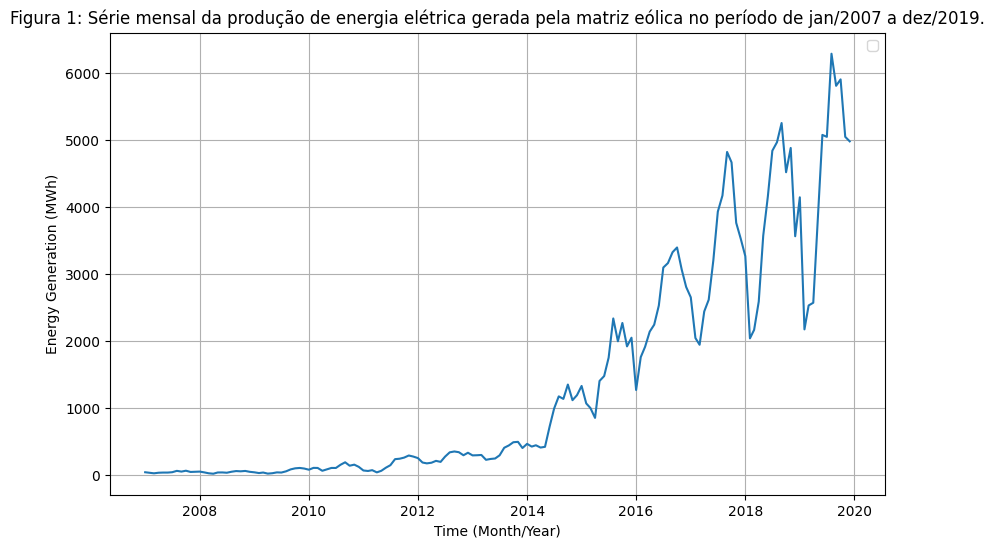

In [489]:
# Plotar os conjuntos de treino e teste
plt.figure(figsize=(10, 6))
plt.plot(df_2007_2019['val_geracao'])
plt.title('Figura 1: Série mensal da produção de energia elétrica gerada pela matriz eólica no período de jan/2007 a dez/2019.')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

Percebe-se também um comportamento periódico indicando um
provável efeito sazonal. Sabe-se que não é possível confirmar essas afirmações sobre as componentes de tendência e/ou sazonalidade visualmente, para isso é necessário aplicar os testes Cox-Stuart e Kruskal-Wallis, respectivamente.

Antes de inferir sobre as componentes supracitadas, é necessário verificar se o modelo é aditivo ou multiplicativo,
confeccionou-se então o gráfico da amplitude versus média, ver Figura 2.

Slope:  0.8737228712974467


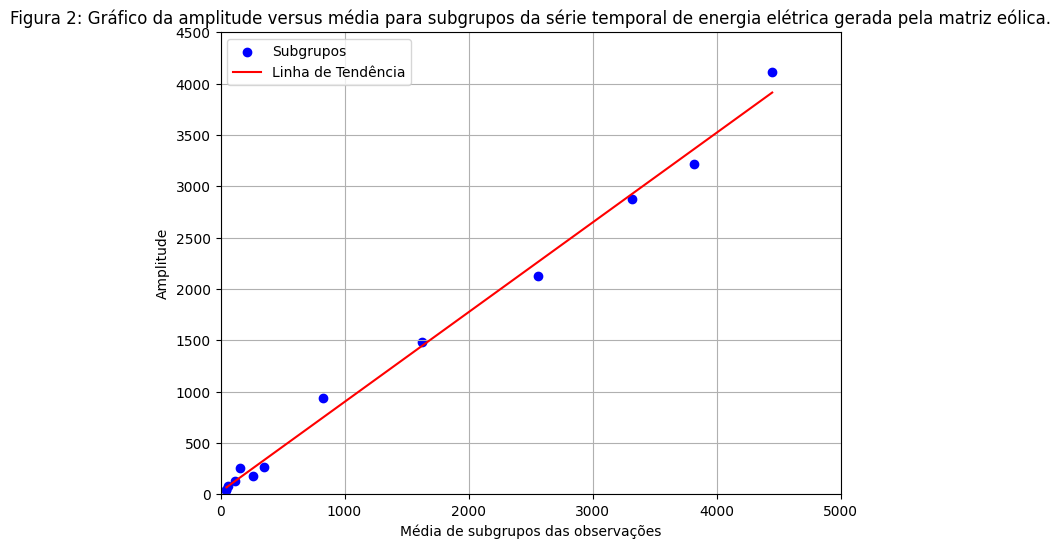

In [490]:
# Dividir a série temporal em subgrupos de tamanho N (por exemplo, 12 meses)
N = 12  # Tamanho do subgrupo (por exemplo, 12 para subgrupos anuais)
subgroups = [df_2007_2019['val_geracao'][i:i + N] for i in range(0, len(df_2007_2019), N)]

# Calcular a média e a amplitude para cada subgrupo
mean_values = [group.mean() for group in subgroups if len(group) == N]
amplitude_values = [group.max() - group.min() for group in subgroups if len(group) == N]

# Regressão linear para a linha de tendência
slope, intercept, r_value, p_value, std_err = linregress(mean_values, amplitude_values)
line = [slope * xi + intercept for xi in mean_values]

print('Slope: ', slope)

# Plotar o gráfico da relação amplitude versus média
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, amplitude_values, color='blue', label='Subgrupos')
plt.plot(mean_values, line, color='red', label='Linha de Tendência')

# Adicionar títulos e rótulos
plt.title('Figura 2: Gráfico da amplitude versus média para subgrupos da série temporal de energia elétrica gerada pela matriz eólica.')
plt.xlabel('Média de subgrupos das observações')
plt.ylabel('Amplitude')

# Ajustar limites dos eixos para corresponder ao gráfico original
plt.xlim(0, 5000)
plt.ylim(0, 4500)

# Adicionar grade
plt.grid(True)

# Mostrar legenda
plt.legend()

# Exibir o gráfico
plt.show()

Através desse gráfico constatou-se uma relação
positiva entre as médias das observações de subgrupos da série original e a amplitude desses subgrupos, com coeficiente de
inclinação de 0,8715, estimado por meio de uma regressão linear simples.

Foi aplicado o teste t para aferir estatisticamente, se
o coeficiente angular da reta ajustado era significativo.

In [491]:
# Calcular o valor t e o p-valor associado
t_value = slope / std_err
gl = len(mean_values) - 2  # graus de liberdade
p_value = 2 * (1 - t.cdf(np.abs(t_value), gl))

print(f'P-value: {p_value}')

P-value: 1.234568003383174e-13


Como o p-valor encontrado foi menor que 0,01, rejeitou-se a hipótese
nula de que o coeficiente angular da reta é nulo ao nível de 5% de significância, logo o modelo é multiplicativo.

Para torná-lo
aditivo e estabilizar a variância, foi fundamental efetuar uma transformação Box-Cox na escala dos dados. O valor de λ
estimado foi de 0,0864 e a transformação dos dados ocorreu de acordo com a equação 1.

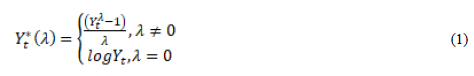

In [492]:
# Aplicar a transformação Box-Cox com λ = 0,0864
lambda_value = 0.0864

df_2007_2019['val_geracao_boxcox'] = boxcox(df_2007_2019['val_geracao'], lmbda=lambda_value)

In [493]:
#df_2007_2019['val_geracao_boxcox'], lam = boxcox(df_2007_2019['val_geracao'])

#print('Lambda: ', lam)

Segundo Ferreira et al. (2020), a existência de uma relação linear crescente ou decrescente entre os pontos do gráfico
da amplitude em função da média indica necessidade de se realizar uma transformação nos dados.

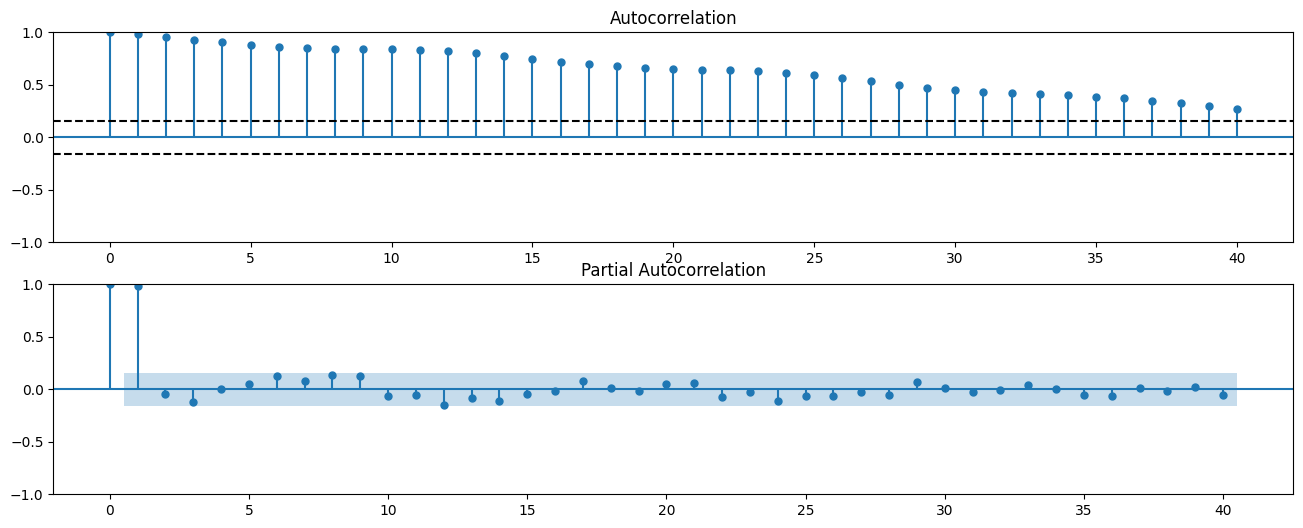

In [494]:
# Plotar ACF e PACF
fig, axes = plt.subplots(2, 1, figsize=(16, 6))
plot_acf(df_2007_2019['val_geracao_boxcox'], lags=40, ax=axes[0], alpha=None)
plot_pacf(df_2007_2019['val_geracao_boxcox'], lags=40, ax=axes[1])

# Customizar o gráfico para ter intervalos de confiança constantes
conf_interval = 1.96 / np.sqrt(len(df_2007_2019['val_geracao_boxcox']))
axes[0].axhline(y=conf_interval, linestyle='--', color='black')
axes[0].axhline(y=-conf_interval, linestyle='--', color='black')

plt.show()

Nota-se pelo correlograma da função de autocorrelação (FAC) da Figura 3 que a série temporal transformada não é
estacionária, pois as defasagens decaem lentamente para zero. Na função de autocorrelação parcial (FACP) observam-se
correlações maiores nas defasagens 1 e 3, com uma propensão para zero nas defasagens seguintes, evidenciando um provável
processo de médias móveis.

In [495]:
df_2007_2019['val_geracao_boxcox']

date
2007-01-01     4.492393
2007-02-01     4.211794
2007-03-01     3.895770
2007-04-01     4.252526
2007-05-01     4.335064
                ...    
2019-08-01    13.067748
2019-09-01    12.899765
2019-10-01    12.934349
2019-11-01    12.604558
2019-12-01    12.576506
Name: val_geracao_boxcox, Length: 156, dtype: float64

In [496]:
# Função do teste de Cox-Stuart baseada na metodologia do artigo
def cox_stuart_test(data):
    n = len(data)
    #print('Length: ', n)
    c = n // 2 if n % 2 == 0 else (n + 1) // 2
    
    first_half = data[:c]
    second_half = data[c:]
    #print('second half: ', second_half)

    # Garantir que os comprimentos das metades sejam iguais
    if len(first_half) != len(second_half):
        second_half = second_half[:len(first_half)]
    
    differences = np.sign(second_half.values - first_half.values)
    #print('differences: ', differences)

    positive_differences = np.sum(differences == 1)
    negative_differences = np.sum(differences == -1)
    ties = np.sum(differences == 0)
    
    n_non_ties = positive_differences + negative_differences
    
    if n_non_ties == 0:
        p_value = 1.0
    else:
        # Calcular p-valor usando a distribuição binomial
        T = min(positive_differences, negative_differences)
        p_value = 2 * binom.cdf(T, n_non_ties, 0.5)
    
    return p_value


# Realizar o teste de Cox-Stuart na série transformada
p_value = cox_stuart_test(df_2007_2019['val_geracao_boxcox'])

print('Teste de Cox-Stuart p-valor: ', p_value)

Teste de Cox-Stuart p-valor:  6.617444900424222e-24


Através do teste de Cox-Stuart (Santos, 2021), verificou-se a existência da componente de tendência com um p-valor de 0,01,
rejeitando, ao nível de 5% de significância, a hipótese nula de não existência de tendência. Dessa forma, foi preciso realizar
uma diferença de ordem 1 na série transformada com o intuito de retirar o efeito da tendência.

In [497]:
# Aplicar a diferença de ordem 1 na série transformada para remover a tendência
df_2007_2019['val_geracao_boxcox_diff'] = df_2007_2019['val_geracao_boxcox'].diff().dropna()

df_2007_2019

,year,month,val_geracao,val_geracao_boxcox,val_geracao_boxcox_diff
date,,,,,
2007-01-01,2007,1,44.518780,4.492393,NaN
2007-02-01,2007,2,36.306070,4.211794,-0.280599
2007-03-01,2007,3,28.729610,3.895770,-0.316023
2007-04-01,2007,4,37.405240,4.252526,0.356755
2007-05-01,2007,5,39.726350,4.335064,0.082538
...,...,...,...,...,...
2019-08-01,2019,8,6287.175894,13.067748,0.463122
2019-09-01,2019,9,5808.611756,12.899765,-0.167983
2019-10-01,2019,10,5904.325176,12.934349,0.034584


O teste de Kruskal-Wallis foi aplicado e o resultado do p-valor foi de 0,7633, não rejeitando, ao nível de 5% de
significância, a hipótese nula de ausência de sazonalidade determinística, isto é, a série não necessita de uma diferença que
considere a ordem de variação no período s.

In [498]:
# Função para realizar o teste de Kruskal-Wallis
def kruskal_wallis_test(data, period):
    # Agrupar dados por períodos
    grouped_data = [data[i::period] for i in range(period)]
    
    # Executar o teste de Kruskal-Wallis
    stat, p_value = kruskal(*grouped_data)
    
    return stat, p_value

# Realizar o teste de Kruskal-Wallis na série transformada
period = 12  # Considerando sazonalidade anual
stat, p_value = kruskal_wallis_test(df_2007_2019['val_geracao_boxcox'], period)

# Mostrar o valor da estatística do teste e o p-valor com mais casas decimais
print(f'Teste de Kruskal-Wallis estatística: {stat:.5f}, p-valor: {p_value:.5f}')

Teste de Kruskal-Wallis estatística: 7.26737, p-valor: 0.77704


A Figura 4 apresenta os correlogramas da FAC e FACP para a série temporal transformada com uma diferença de
ordem 1.

In [502]:
def calculate_acf(series, nlags):
    n = len(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n

    acf_values = []
    for lag in range(nlags + 1):
        clag = np.sum((series[:n-lag] - mean) * (series[lag:] - mean)) / n
        acf_values.append(clag / c0)
    
    return acf_values

# Calcular ACF manualmente
nlags = 36
acf_values = calculate_acf(df_2007_2019['val_geracao_boxcox_diff'].dropna(), nlags)


def calculate_pacf(series, nlags):
    pacf_values = [1.0]
    for k in range(1, nlags + 1):
        reg_matrix = np.array([series.shift(i) for i in range(1, k+1)]).T[k-1:]
        reg_matrix = reg_matrix[~np.isnan(reg_matrix).any(axis=1)]
        y = series[k-1:].dropna()
        if len(reg_matrix) > 0 and len(y) > 0:
            beta = np.linalg.lstsq(reg_matrix, y[:len(reg_matrix)], rcond=None)[0]
            pacf_values.append(beta[-1])
        else:
            pacf_values.append(np.nan)
    return pacf_values

# Calcular PACF manualmente
pacf_values = calculate_pacf(df_2007_2019['val_geracao_boxcox_diff'].dropna(), nlags)

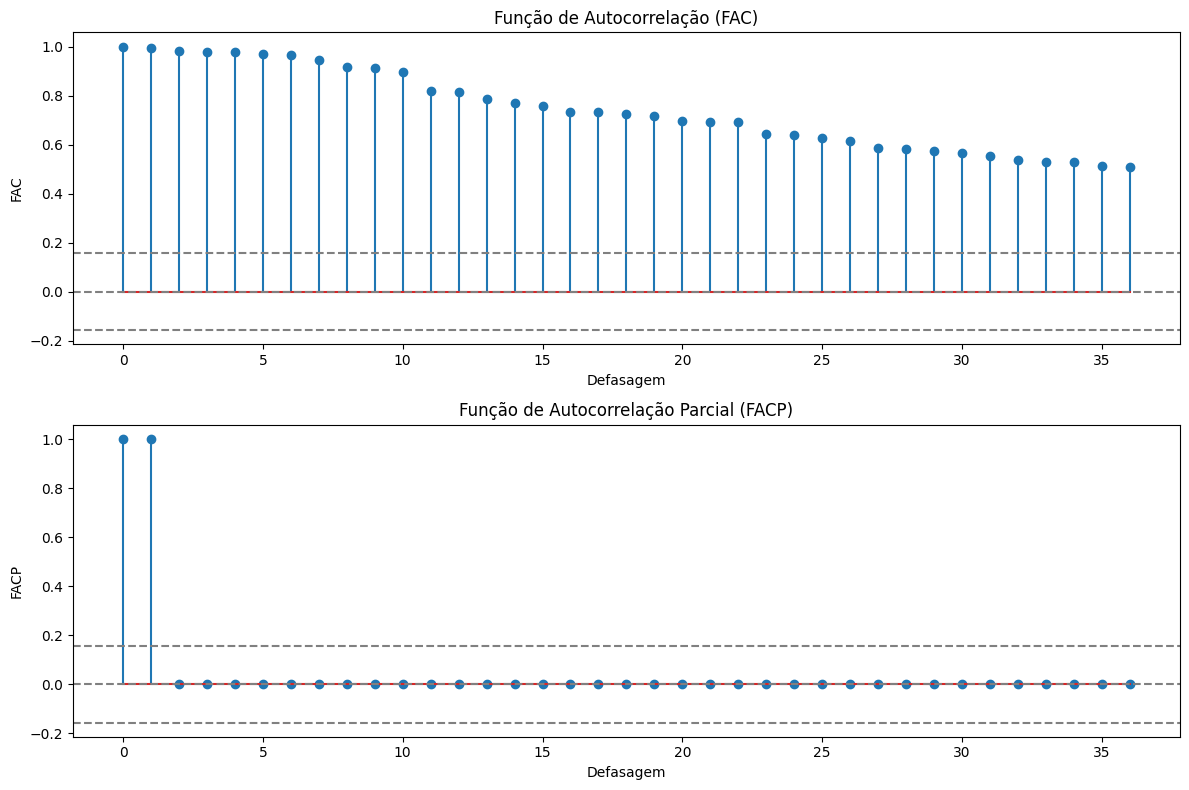

In [503]:
# Plotar FAC manualmente
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.stem(range(len(acf_values)), acf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_2007_2019['val_geracao_boxcox_diff'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_2007_2019['val_geracao_boxcox_diff'])), linestyle='--', color='gray')
plt.title('Função de Autocorrelação (FAC)')
plt.xlabel('Defasagem')
plt.ylabel('FAC')

# Plotar FACP manualmente
plt.subplot(212)
plt.stem(range(len(pacf_values)), pacf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_2007_2019['val_geracao_boxcox_diff'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_2007_2019['val_geracao_boxcox_diff'])), linestyle='--', color='gray')
plt.title('Função de Autocorrelação Parcial (FACP)')
plt.xlabel('Defasagem')
plt.ylabel('FACP')

plt.tight_layout()
plt.show()

In [ ]:
# Apresentar os correlogramas da FAC e FACP para a série temporal transformada com uma diferença de ordem 1
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df_2007_2019['val_geracao_boxcox_diff'].dropna(), lags=36, ax=axes[0], alpha=None, zero=False)
conf_interval = 1.96 / np.sqrt(len(df_2007_2019['val_geracao_boxcox_diff']))
axes[0].axhline(y=conf_interval, linestyle='--', color='gray')
axes[0].axhline(y=-conf_interval, linestyle='--', color='gray')
axes[0].set_title('FAC')
axes[0].set_xlabel('Defasagem')
axes[0].set_ylabel('FAC')

plot_pacf(df_2007_2019['val_geracao_boxcox_diff'].dropna(), lags=36, ax=axes[1], alpha=, zero=False)
axes[1].axhline(y=conf_interval, linestyle='--', color='gray')
axes[1].axhline(y=-conf_interval, linestyle='--', color='gray')
axes[1].set_title('FACP')
axes[1].set_xlabel('Defasagem')
axes[1].set_ylabel('FACP')

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (824857790.py, line 12)

A partir do correlograma da FACP, pode-se perceber a autocorrelação significamente diferente de zero nas
defasagens 2, 3, 4, 5 e 6, indicando as possíveis ordens do modelo para a parte autorregressiva ”p”. Como não existem
defasagens significativas múltiplas de 12 na FACP, a ordem sazonal de “P” é zero. No correlograma da FAC, as defasagens
significativas são 2, 3, 5, 6, 7, 8, 11, 12, 13, 16, 17, 18, 19, 23, 24, 25 e 35, indicando as possíveis ordens do modelo para a
parte de médias móveis ”q”. Como apareceram defasagens múltiplas de 12 significativas na FAC, a provável ordem sazonal de
“Q” é dois. Assim, foi possível propor vários modelos SARIMA (p,d,q)×(P,D,Q)S.

Dentre os modelos ajustados, buscaram-se aqueles com comportamento de ruído branco nos resíduos, isto é,
apresentaram o p-valor superior a 5% para o teste de Ljung-Box. Destes, selecionaram aqueles que tiveram menor critério de
informação de Akaike (AIC), levando-se em conta o princípio da parcimônia, ou seja, menor número de parâmetros.

In [ ]:
# Definir os diferentes conjuntos de parâmetros SARIMA
models = [
    {'order': (5, 1, 2), 'seasonal_order': (0, 0, 2, 12)},
    {'order': (5, 1, 2), 'seasonal_order': (0, 0, 1, 12)},
    {'order': (4, 1, 2), 'seasonal_order': (0, 0, 1, 12)},
    {'order': (5, 1, 2), 'seasonal_order': (1, 0, 1, 12)},
    {'order': (5, 1, 2), 'seasonal_order': (0, 0, 3, 12)},
    {'order': (3, 1, 1), 'seasonal_order': (0, 1, 1, 12)},
]

# Lista para armazenar os resultados
results = []

In [ ]:
# Ajustar cada modelo, calcular AIC e √EQMP
for model_params in models:
    model = SARIMAX(df_2007_2019['val_geracao_boxcox'], order=model_params['order'], seasonal_order=model_params['seasonal_order'])
    model_fit = model.fit(disp=False)
    
    # Calcular AIC
    aic = model_fit.aic
    
    # Fazer previsões no conjunto de teste
    pred_start = test.index[0]
    pred_end = test.index[-1]
    predictions_boxcox = model_fit.predict(start=pred_start, end=pred_end, dynamic=False)
    
    # Inverter a transformação Box-Cox nas previsões
    predictions = inv_boxcox(predictions_boxcox, lam)
    
    # Calcular √EQMP
    mse = mean_squared_error(test['val_geracao'], predictions)
    rmse = np.sqrt(mse)
    
    # Adicionar resultados à lista
    results.append({
        'SARIMA': f"{model_params['order']}x{model_params['seasonal_order']}",
        'AIC': aic,
        '√EQMP': rmse
    })

# Criar DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibir a tabela
print(results_df)

e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\base\model.py

                    SARIMA        AIC        √EQMP
0  (5, 1, 2)x(0, 0, 2, 12) -41.809043   869.955731
1  (5, 1, 2)x(0, 0, 1, 12) -42.807200   881.644476
2  (4, 1, 2)x(0, 0, 1, 12) -44.820919   862.438286
3  (5, 1, 2)x(1, 0, 1, 12) -29.526263  1194.751444
4  (5, 1, 2)x(0, 0, 3, 12) -36.020507   753.424231
5  (3, 1, 1)x(0, 1, 1, 12) -24.933346  1360.261296


In [ ]:
# Dividir os dados em treino (jan/2007 a dez/2019) e teste (jan/2020 a mar/2021)
train = df.loc['2007-01':'2019-12']
test = df.loc['2020-01':'2021-03']

# Transformação Box-Cox
train['val_geracao_boxcox'], lam = boxcox(train['val_geracao'])
test['val_geracao_boxcox'] = boxcox(test['val_geracao'], lmbda=lam)

C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_24820\1206071467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['val_geracao_boxcox'], lam = boxcox(train['val_geracao'])
C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_24820\1206071467.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['val_geracao_boxcox'] = boxcox(test['val_geracao'], lmbda=lam)


In [ ]:
# Função para inverter a transformação Box-Cox
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lam * y + 1) / lam)

In [ ]:
# Definir os diferentes conjuntos de parâmetros SARIMA
models = [
    {'order': (5, 1, 2), 'seasonal_order': (0, 0, 2, 12)},
    {'order': (5, 1, 2), 'seasonal_order': (0, 0, 1, 12)},
    {'order': (4, 1, 2), 'seasonal_order': (0, 0, 1, 12)},
    {'order': (5, 1, 2), 'seasonal_order': (1, 0, 1, 12)},
    {'order': (5, 1, 2), 'seasonal_order': (0, 0, 3, 12)},
    {'order': (3, 1, 1), 'seasonal_order': (0, 1, 1, 12)},
]

# Lista para armazenar os resultados
results = []

In [ ]:
# Ajustar cada modelo, calcular AIC e √EQMP
for model_params in models:
    model = SARIMAX(train['val_geracao_boxcox'], order=model_params['order'], seasonal_order=model_params['seasonal_order'])
    model_fit = model.fit(disp=False)
    
    # Calcular AIC
    aic = model_fit.aic
    
    # Fazer previsões no conjunto de teste
    pred_start = test.index[0]
    pred_end = test.index[-1]
    predictions_boxcox = model_fit.predict(start=pred_start, end=pred_end, dynamic=False)
    
    # Inverter a transformação Box-Cox nas previsões
    predictions = inv_boxcox(predictions_boxcox, lam)
    
    # Calcular √EQMP
    mse = mean_squared_error(test['val_geracao'], predictions)
    rmse = np.sqrt(mse)
    
    # Testes de diagnóstico de resíduos
    ljung_box = acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)
    normality_test = jarque_bera(model_fit.resid)
    
    # Adicionar resultados à lista
    results.append({
        'SARIMA': f"{model_params['order']}x{model_params['seasonal_order']}",
        'AIC': aic,
        '√EQMP': rmse,
        'Ljung-Box p-value': ljung_box['lb_pvalue'].values[0],
        'Normality Test p-value': normality_test[1]
    })

# Criar DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibir a tabela
print(results_df)

e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\base\model.py

                    SARIMA        AIC        √EQMP  Ljung-Box p-value  \
0  (5, 1, 2)x(0, 0, 2, 12) -41.809043   869.955731           0.912088   
1  (5, 1, 2)x(0, 0, 1, 12) -42.807200   881.644476           0.926652   
2  (4, 1, 2)x(0, 0, 1, 12) -44.820919   862.438286           0.898716   
3  (5, 1, 2)x(1, 0, 1, 12) -29.526263  1194.751444           0.962263   
4  (5, 1, 2)x(0, 0, 3, 12) -36.020507   753.424231           0.927908   
5  (3, 1, 1)x(0, 1, 1, 12) -24.933346  1360.261296           0.867197   

   Normality Test p-value  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
5                     0.0  
